In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define the DeepDream model
class DeepDream(nn.Module):
    def __init__(self, model, layer_idx):
        super(DeepDream, self).__init__()
        self.features = self.get_required_layers(model, layer_idx)

    def forward(self, x):
        return self.features(x)

    def get_required_layers(self, model, layer_idx):
        if isinstance(model, nn.Sequential):
            return nn.Sequential(*list(model.children())[:layer_idx+1])
        elif isinstance(model, nn.Module):
            return model  # You might need to adjust this depending on the structure of your model
        else:
            raise ValueError("Unsupported model type")

In [3]:
# Function to perform deep dream on an image
def deep_dream(image_path, model, layer_idx, iterations, lr, octave_scale, output_path):
    # Load the image
    img = Image.open(image_path).convert('RGB')
    img = transforms.ToTensor()(img).unsqueeze(0)
    img = nn.Parameter(img.to(device))

    # Define the deep dream model
    dream_model = DeepDream(model, layer_idx).to(device)

    # Define the optimizer
    optimizer = optim.Adam([img], lr=lr)

    # DeepDream iterations
    for i in range(iterations):
        optimizer.zero_grad()
        features = dream_model(img)
        loss = features.norm()
        loss.backward()
        optimizer.step()

        # Apply the octave scaling
        img.data = img.data + octave_scale * img.grad.data

        # Zero the gradient
        img.grad.data.zero_()

        # Clip the image values to be in the valid range
        img.data = torch.clamp(img.data, 0, 1)

    # Save the final deep dream image
    result = transforms.ToPILImage()(img.squeeze(0).cpu())
    result.save(output_path)

In [4]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a pre-trained model (e.g., VGG16)
model = models.inception_v3(pretrained=True).eval().to(device)

# Specify the layer index for deep dream (you can experiment with different layers)
layer_index = 10

# Specify the parameters
input_image_path = 'YellowLabradorLooking_new.jpg'
iterations = 100
learning_rate = 0.01
octave_scale = 1.4
output_image_path = "YellowLabradorDeepdream.jpg"

# Run deep dream
deep_dream(input_image_path, model, layer_index, iterations, learning_rate, octave_scale, output_image_path)

/home/user/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


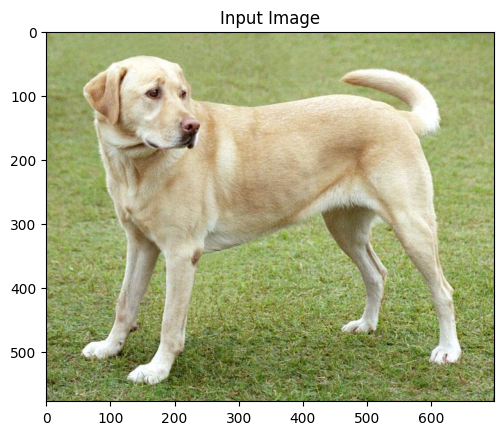

In [5]:
# Display the input image
input_img = Image.open(input_image_path)
plt.imshow(input_img)
plt.title("Input Image")
plt.show()

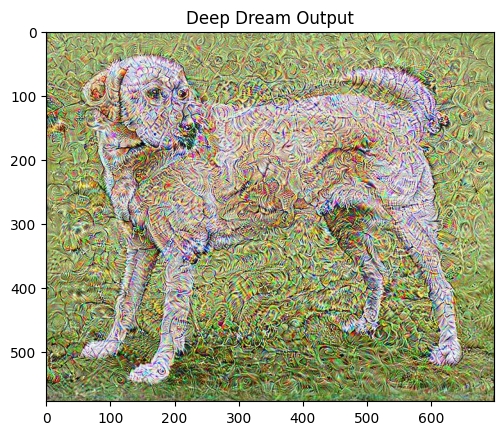

In [6]:
# Display the output image
output_img = Image.open(output_image_path)
plt.imshow(output_img)
plt.title("Deep Dream Output")
plt.show()